In [ ]:
# The following code is conducted on the LUNA16 dataset, collected from the link: 
# https://zenodo.org/record/2595813

In [1]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
from cv2 import blur
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import disk, binary_erosion, binary_closing
from skimage.filters import roberts
import matplotlib.pyplot as plt
import random
from random import randint
import pickle
import os
from sklearn.model_selection import train_test_split
import statistics as stats
import functools

# Limiting Data to Selected Subset

In [ ]:
# Load the candidates csv file into a dataframe.
df = pd.read_csv("D:\\School Work\\University\\Modules\\Year 3\\Machine Learning\\Project\\candidates_V2.csv")
df

In [ ]:
index_values = []

# For every CT scan file, use the name and find all nodule records in the candidates file.
for file in os.scandir("D:\\School Work\\University\\Modules\\Year 3\\Machine Learning\\Project\\Dataset\\Raw Data\\"):
    # Files are stored in .raw and .mhd file types, only check the .mhd files.
    if file.name[-4:] == ".mhd":
        # Ensure that the file that is currently selected is inside of the candidates dataframe.
        if file.name[:-4] in df["seriesuid"].values:
            # Find all indeces that match the name of the CT scan file.
            indeces = df.index[df["seriesuid"] == file.name[:-4]].values

            # Append the index / indeces into the index_values list.
            if len(indeces) > 1:
                for i in indeces:
                    index_values.append(i)
            else:
                index_values.append(indeces[0])

In [ ]:
# Create new dataframe with located nodule points.
copy_df = df.loc[index_values]

# Set new index.
s = pd.Series(list(range(len(copy_df))))
copy_df = copy_df.set_index(s)

# Get only the nodule points labelled "1" (Positive nodule).
candidates_lim_1 = copy_df[copy_df["class"] == 1]
candidates_lim_1

# Set new index.
s = pd.Series(list(range(len(candidates_lim_1))))
final_lim = candidates_lim_1.set_index(s)

final_lim.to_csv("true_candidates_limited.csv", index=False)

# Data Preparation

In [ ]:
# Source: https://www.kaggle.com/code/arnavkj95/candidate-generation-and-luna16-preprocessing

### Functions to convert ct_scan to array and converting coordinates

In [2]:
# Load_itk function, taking the file name and converting the ct_scan to return relevant information.
def load_itk(filename):
    # Using the sitk.ReadImage function, read and load the file.
    itkimage = sitk.ReadImage(filename)

    # Convert the ct_scan into a 3D array.
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Retrieve the origin from the source image.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Retrieve the spacing from the source image.
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan, origin, spacing

# Takes the real world cordinates as input, along with origin and spacing to return voxel coordinates.
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

# Takes the voxel coordinates as input, along with origin and spacing to return real world coordinates.
def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

### Apply chosen filters on all slices in all ct scans

In [ ]:
# The following snippet of code generates new CT Scans that have been passed through a filter.

# Iterate through every CT scan file.
for file in os.scandir("D:/School Work/University/Modules/Year 3/Machine Learning/Project/Dataset/Raw Data/"):
    if file.path[-4:] == ".mhd":
        ct_slices = sitk.GetArrayFromImage(sitk.ReadImage(file.path))
        
        # Median Filter applied on every CT slice in the current file.
        med_filtered_scan = np.asarray([ndi.median_filter(ct_slice, (5,5)) for ct_slice in ct_slices])
        
        # Mean Filter applied on every CT slice in the current file.
        mean_filtered_scan = np.asarray([blur(ct_slice, (5,5)) for ct_slice in ct_slices])
        
        # Gaussian Filter applied on every CT slice in the current file.
        gau_filtered_scan = np.asarray([ndi.gaussian_filter(ct_slice, sigma=1.5) for ct_slice in ct_slices])

        # Save each filtered scan to according location.
        np.save(("D:/School Work/University/Modules/Year 3/Machine Learning/Project/Dataset/Unsegmented Median Filter/Median_Filtered_" + file.name[:-4]), med_filtered_scan)
        np.save(("D:/School Work/University/Modules/Year 3/Machine Learning/Project/Dataset/Unsegmented Mean Filter/Mean_Filtered_" + file.name[:-4]), mean_filtered_scan)
        np.save(("D:/School Work/University/Modules/Year 3/Machine Learning/Project/Dataset/Unsegmented Gaussian Filter/Gaussian_Filtered_" + file.name[:-4]), gau_filtered_scan)

### Image Segmentation

In [ ]:
# The following function carries out the image segmentation of a single lung image slice
# through a series of operations.

def get_segmented_lungs(im):
    #Convert into binary image -> Black and white.
    binary = im < 604
        
    #Remove the blobs connected to the border of the image.
    cleared = clear_border(binary)
        
    #Label the image -> split up different parts in image.
    label_image = label(cleared)
        
    #Keep the labels with 2 largest areas -> Removes irrelevant parts.
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:
                    label_image[coordinates[0], coordinates[1]] = 0
                    
    binary = label_image > 0
        
    #Erosion operation to separate lung nodules from attached blood vessels.
    selem = disk(2)
    binary = binary_erosion(binary, selem) # -> binary array is being eroded by selem array.
        
    #Closure operation to keep nodules attached to lung wall.
    selem = disk(10)
    binary = binary_closing(binary, selem) #-> binary array closed by seleme array. Fills in the black gaps.
        
    #Fill holes inside binary mask.
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges) #Fill any holes left in the image through finding of edges.
        
    #Superimpose the created mask onto input image.
    get_high_values = binary == 0
    im[get_high_values] = 0
        
    return im

In [ ]:
# A wrapper function to ease the use of the "get_segmented_lungs" function.
def segment_lung_from_ct_scan(image):   
    # Add 1024 to deal with intensity values.
    lung_img = image + 1024
    
    # A single 3D array of the lungs are taken, and each slice is passed through the segmentation function.
    return np.asarray([get_segmented_lungs(ct_slice) for ct_slice in lung_img])

### Generate the segmented slices on the ct scans

In [ ]:
# To note: this code creates segmented images on the RAW data.

# For testing with only image segmentation data, the raw data is iterated over and segmented.
for file in os.scandir("D:/School Work/University/Modules/Year 3/Machine Learning/Project/Dataset/Raw Data/"):
    if file.path[-4:] == ".mhd":
        # Load the CT scan from the .mhd file into an array
        ct_slices = sitk.GetArrayFromImage(sitk.ReadImage(file.path))
        
        # Call the segmentation function with the CT scan as the input.
        # The function returns a segmented CT scan.
        segmented_ct_scan = segment_lung_from_ct_scan(ct_slices)
        
        np.save(("D:/School Work/University/Modules/Year 3/Machine Learning/Project/Dataset/Segmented Scans/Segmented_Scan_" + file.name[:-4]), segmented_ct_scan)

### Generate the segmented slices on all ct scans (filtered data - np files)

In [ ]:
# To note: this code creates segmented images on the FILTERED data

# In this case, the code is used to iterate over the previously mean filtered data.
# To segment other filters, this directory should be switched to the according data.
for file in os.scandir("D:/School Work/University/Modules/Year 3/Machine Learning/Project/Dataset/Unsegmented Mean Filter/"):
    
    # The file is loaded, this being the 3D array of the lungs (Entire CT scan)
    ct_slices = np.load(file.path)
    
    # The file is then input to the segmentation function.
    segmented_ct_scan = segment_lung_from_ct_scan(ct_slices)
    
    # This new segmented image is then saved as an array.
    # Note: Remember to change the directory when changing the filter.
    np.save(("D:/School Work/University/Modules/Year 3/Machine Learning/Project/Dataset/Segmented Mean Scans/Segmented_" + file.name[:-4]), segmented_ct_scan)

### Function for creating voxels from coordinates, and random point generation

In [ ]:
# Function to create cubic voxels from lung image and coordinates.
def get_patch_from_list(lung_img, coords):
    shape = lung_img.shape
    output = []
    # Add 1024 to deal with intensity values
    lung_img = lung_img + 1024
    
    # For every coordinate listing, get the x, y, and z
    # then slice the lung image in 36x36x36 cubes based on the nodule coordinate points.
    for i in range(len(coords)):
        # +18 and -18 determine the area to slice (18+18=36).
        # To increase or decrease voxel array, these should be changed.
        patch = lung_img[coords[i][0] - 18: coords[i][0] + 18, 
                         coords[i][1] - 18: coords[i][1] + 18, 
                         coords[i][2] -18: coords[i][2] + 18]
        
        # This creates new, smaller 3D arrays that are stored as the output.
        output.append(patch)
    
    return output

# Function to generate random coordinates to cut in the lung image space (shape).
def get_point(shape):
    
    # The values for each direction is subtracted by a certain amount to ensure coordinates
    # are within the lung image, as different lungs have different shapes.
    x = randint(50, shape[2] - 50)
    z = randint(50, shape[1] - 50)
    y = randint(20, shape[0] - 20)
    
    # To reduce the chance of overlapping, these values can be decreased however this
    # can cause errors as there is the chance of slicing an image outside of its area (invalid array slice)
    
    return np.asarray([y,z,x])

### The first function used on raw data

In [ ]:
# The function "create_data_raw" takes the previously identified nodule points, their coordinates and corresponding
# lung image, in order to generate the training and testing data. These new cubic voxels generated are stored in pickled
# files for faster interaction. Two inputs are required, this being the path to the raw ct scans and 
# to the coordinates file.
def create_data_raw(path, csv_path):
    coords, Y = [], []  
    # Set counter for each file.
    counter = 0

    # Iterate over every single nodule point in the candidates file.
    for value in csv_path.values:
                    
        # Generate an image, its origin and spacing using the path and the filename (coming from "value", 0 implying 
        # the first column).
        lung_img, origin, spacing = load_itk(path + value[0] + ".mhd")
        
        # From a single nodule point, 3 for loops are used to collect 48 positive data point coordinates.
        # A nodule point is examined based on various angles, creating a range of new coordinate values
        # by adding the i, j and k to them.
        
        # This is conducting data augmentation to create more data, as there was a much smaller number
        # of available positively labelled nodule points. To increase the data more, these for loop
        # ranges can be adjusted accordingly.
        for i in range(-5, 5, 3):
            for j in range(-5, 5, 3):
                for k in range(-2, 3, 2):
                    # Differing from ArnavJain's code, the coordinates are converted into voxel coordinates, 
                    # then rounded, instead of taking integers, for more accurate cuts 
                    # as real-world coordinates lead to many invalid array slices.
                    voxel_coords = np.round_(world_2_voxel(np.array((value[3]+k,value[2]+j,value[1]+i)),origin,spacing)).astype(int)       
                    coords.append(voxel_coords)
                    Y.append(1) #True Nodes
    
        # For the negative data points, random coordinates are generated depending on the shape (input argument)   
        # of the current lung image. To match the positive data, the range is set to 48 to keep the data balanced.
        # Should the number of data points want to be incremented, this range should be changed
        # to match the number of positive data points.
        for i in range(48):
            coords.append(get_point(lung_img.shape))
            Y.append(0) #False nodules
            
        # To retrieve the cut out voxel, the "get_patch_from_list" function that was previously defined is called.
        # The current lung image and its coordinates are used as input.
        X = get_patch_from_list(lung_img, coords)           
        
        # Once the data has been generated, every X data point must be checked to ensure consistency.
        # First check that the first point is of correct shape, if not ignore this list.
        if X[0].shape == (36,36,36):
            # For every value, check that each data point has a 36x36x36 shape, if it does not,
            # the list is cleared and the for loop is broken.
            for i in X:
                if i.shape != (36,36,36):
                    X.clear()
                    break
                    
            # If every single data point in the list has a shape of 36x36x36 (length of the list is not 0),
            # then the X and Y data is pickled, with an assigned number for the file and the description "Raw"
            # as the data used in this code has not been modified.
            if len(X) != 0:
                pickle.dump(np.asarray(X), open(f"D:/School Work/University/Modules/Year 3/Machine Learning/Project/Dataset/Pickled Data/Xdata_{str(counter)}_Raw.p", "wb"))
                pickle.dump(np.asarray(Y, dtype=bool), open(f"D:/School Work/University/Modules/Year 3/Machine Learning/Project/Dataset/Pickled Data/Ydata_{str(counter)}_Raw.p", "wb"))

        counter += 1
        # Clear the coordinates and Y point list to be used for the next lung image
        coords, Y = [], []

In [ ]:
# This code creates the cubic voxels from RAW data.

# Here the path and the folder of raw data are set.
csv_path = pd.read_csv("true_candidates_limited.csv")
main_path = "D:\\School Work\\University\\Modules\\Year 3\\Machine Learning\\Project\\Dataset\\Raw Data\\"

# These are then input into the create_data_raw function, where the data is generated.
create_data_raw(main_path, csv_path)

### The second function which generates data from segmented images

In [ ]:
# The function "create_segment_data" takes the modified images (filtered, segmented and/or both) in order 
# to generate the training and testing data. These new cubic voxels generated are stored in pickled
# files for faster interaction. 

# This time, five inputs are required, this being the path to the raw ct scans, the path to the modified files, 
# the path to the coordinates file, the initial header of the modified files, and the output path directory.
def create_segment_data(path, alt_path, train_csv_path, file_header, output_path):
    coords, trainY = [], []  
    # Set counter for each file
    counter = 0

    # Iterate over every single nodule point in the candidates file.
    for value in train_csv_path.values:
        
        # Using the raw data path, get the origin and spacing of the image.
        old_img, origin, spacing = load_itk(path + value[0] + ".mhd")
        
        # The modified lung image is loaded from the saved files using the alt_path directory.
        # The filename name is found using the train_csv_path (row 0, implying the first column)
        lung_img = np.load(alt_path + file_header + value[0] + ".npy")
        
        # From this point the process remains largely the same as the base model function.
        for i in range(-5, 5, 3):
            for j in range(-5, 5, 3):
                for k in range(-2, 3, 2):
                    voxel_coords = np.round_(world_2_voxel(np.array((value[3]+k,value[2]+j,value[1]+i)),origin,spacing)).astype(int)       
                    coords.append(voxel_coords)
                    trainY.append(1) #True Nodes
    
        for i in range(48):
            coords.append(get_point(lung_img.shape))
            trainY.append(0) #False nodules
            
        trainX = get_patch_from_list(lung_img, coords) 
        
        if trainX[0].shape == (36,36,36):
            for i in trainX:
                if i.shape != (36,36,36):
                    trainX.clear()
                    break
                    
            # Use the newly input output directory.
            if len(trainX) != 0:
                pickle.dump(np.asarray(trainX), open(f"{output_path}traindata_{str(counter)}_Xtrain.p", "wb"))
                pickle.dump(np.asarray(trainY), open(f"{output_path}traindata_{str(counter)}_Ytrain.p", "wb"))
        
        counter += 1
        # Clear the coordinates and Y point list to be used for the next lung image
        coords, trainY = [], []

In [ ]:
# This code creates the cubic voxels from MODIFIED data.

# Specificy the directory where the coordinates are located, and load it.
train_csv_path = pd.read_csv("true_candidates_limited.csv")

# Main path remains the same, as the origin and spacing of each CT scan are still required.
# The alt_path (alternative path), file_header, and output path are adjusted depending on which data will be generated.
main_path = "D:\\School Work\\University\\Modules\\Year 3\\Machine Learning\\Project\\Dataset\\Raw Data\\"
alt_path = "D:\\School Work\\University\\Modules\\Year 3\\Machine Learning\\Project\\Dataset\\Segmented Mean Scans\\"
file_header = "Segmented_Mean_Filtered_"
output_path = "D:/School Work/University/Modules/Year 3/Machine Learning/Project/Dataset/Pickled Mean Filter/"

# Input the main path for the raw data, the alt_path for the modified data, and the train_csv_path for nodule coordinates.
create_segment_data(main_path, alt_path, train_csv_path, file_header, output_path)

# Data Loading and Train/Test splitting

In [ ]:
data_x_lst = []
data_y_list = []

# Load the pickled data into two lists, one for x data points and one for y data points.
# Note: Ensure that the correct directory is selected. Here the base pickled data is chosen.
for file in os.scandir("D:/School Work/University/Modules/Year 3/Machine Learning/Project/Dataset/Pickled Data/"):
    with open(file.path, 'rb') as f:
        array = pickle.load(f)
        
        # Check the file by reading the first 5 digits of the file name.
        if file.name[:5] == "Xdata":
            data_x_lst.append(array)
            
        # If it isn't XData, then it is YData, therefore append it to the y list.
        else:
            data_y_list.append(array)

In [ ]:
# Convert both the lists into arrays.
data_x = np.array(data_x_lst)
data_y = np.array(data_y_list)

# Split the data into training and testing sets, 80% training, 20% testing. Randoms_state is set to 42 for reproducibility.
# Change the "test_size" argument to adjust their sizes.
X_train, X_test, y_train, y_test = train_test_split(data_x,data_y, test_size = 0.20, random_state = 42)

In [ ]:
# Convert both the lists into arrays.
data_x = np.array(data_x_lst)
data_y = np.array(data_y_list)

# Split the data into training and testing sets, 80% training, 20% testing. Randoms_state is set to 42 for reproducibility.
# Change the "test_size" argument to adjust their sizes.
X_train, X_test, y_train, y_test = train_test_split(data_x,data_y, test_size = 0.20, random_state = 42)

# Ensure that the sizes of the sets are correct.
X_train.shape, X_test.shape, y_train.shape,y_test.shape

In [ ]:
# The new training and testing files are saved in case they are not used at the time.
np.save("Dataset/Base_Xtrain_Data.npy", X_train)
np.save("Dataset/Base_Xtest_Data.npy", X_test)
np.save("Dataset/Base_Ytrain_Data.npy", y_train)
np.save("Dataset/Base_Ytest_Data.npy", y_test)

# Model Creation & Training

In [34]:
# To be noted, Tensorflow version 2.10 is used, with Python version 3.9.13 using CUDA computing toolkit.
# For more efficient processing, the GPU is used.
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv3D, MaxPool3D , Flatten, Dropout
from sklearn.metrics import classification_report, precision_score, f1_score, confusion_matrix
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

In [35]:
# Load the previously saved numpy arrays.
X_train = np.load("Dataset/Base_Xtrain_Data.npy")
X_test = np.load("Dataset/Base_Xtest_Data.npy")
Y_train = np.load("Dataset/Base_Ytrain_Data.npy")
Y_test = np.load("Dataset/Base_Ytest_Data.npy")
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((388, 96, 36, 36, 36), (98, 96, 36, 36, 36), (388, 96), (98, 96))

In [36]:
# Generate the base model through a 3D convolutional neural network.
model = Sequential()

# Input shape is 36x36x36, and is gray scaled (therefore 1 - single channel).
# First convolutional layer has 16 filters, all size 3x3x3.
model.add(Conv3D(filters=16, kernel_size=(3,3,3), input_shape=(36, 36, 36, 1)))
model.add(Activation('relu'))
# Followed by 2x2x2 MaxPool3D layer.
model.add(MaxPool3D(pool_size=(2,2,2)))
# Second convolutional layer has 32 filters, all size 3x3x3.
model.add(Conv3D(32, kernel_size=(3,3,3)))
model.add(Activation('relu'))
# Followed by 2x2x2 MaxPool3D layer.
model.add(MaxPool3D(pool_size=(2,2,2)))
# Output of the maxpooling is flattened into a 1-dimensional vector.
model.add(Flatten())
# First fully connected layer has 64 nodes.
model.add(Dense(64))
model.add(Activation('relu'))
# A dropout of 0.5 is added to reduce overfitting.
model.add(Dropout(0.5))
# Second fully connected layer has 32 nodes.
model.add(Dense(32))
model.add(Activation('relu'))
# A small dropout of 0.1 is added to further reduce potential overfitting.
model.add(Dropout(0.1))
# Final output has a single node, for binary classification with sigmoid function.
model.add(Dense(1))
model.add(Activation('sigmoid'))

# Model is then compiled, ready for training.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [44]:
# As the training data is stored in shape (388, 96), there are 388 pickled files for training to iterate over
# with each file having 96 data points. A for loop is utilized to get each file, and train the
# convolutional neural network on batches of 96 data points.
for i in range(len(X_train)):
    model.train_on_batch(X_train[i], Y_train[i], sample_weight=None)

In [45]:
# The same is done on model testing, and prediction generation. There are 98 pickled files for testing to iterate over,
# with each having 96 data points. A for loop is once more utilize to get each file, and predict every data point
# of the 96 in every file.
predictions = []
for i in range(len(X_test)):
    prediction = model.predict_on_batch(X_test[i])
    predictions.append(prediction)

In [46]:
# To ensure that the prediction values and the actual values are in the same structure,
# the predictions are first rounded (to 0 or 1) and then reshaped into a single array containing every value.
# This way the two arrays can be directly input and compared in the classification report and confusion matrix.
y_pred = np.around(np.array(predictions))
y_pred_all = y_pred.reshape(-1,).astype(int)
Y_test_all = Y_test.reshape(-1,)

In [47]:
# Generate classification report.
print(classification_report(Y_test_all, y_pred_all, target_names =["Non-Nodule 0", "Nodule 1"]))

              precision    recall  f1-score   support

Non-Nodule 0       0.83      0.80      0.81      4704
    Nodule 1       0.81      0.84      0.82      4704

    accuracy                           0.82      9408
   macro avg       0.82      0.82      0.82      9408
weighted avg       0.82      0.82      0.82      9408



In [48]:
# Generate classification report as dictionary.
class_rep = classification_report(Y_test_all, y_pred_all, target_names =["Non-Nodule 0", "Nodule 1"], output_dict=True)
# Retrieve specific metrics, multiply by 100 to convert into percentages and get the first two decimal points.
print("Accuracy: {:.2f}".format(class_rep["accuracy"] * 100))
print("Precision: {:.2f}".format(class_rep["Nodule 1"]["precision"] * 100))
print("Sensitivity: {:.2f}".format(class_rep["Nodule 1"]["recall"] * 100))
print("Specificity: {:.2f}".format(class_rep["Non-Nodule 0"]["recall"] * 100))
print("F1-Score: {:.2f}".format(class_rep["Nodule 1"]["f1-score"] * 100))

Accuracy: 81.83
Precision: 80.53
Sensitivity: 83.97
Specificity: 79.70
F1-Score: 82.21


In [49]:
# Generate confusion matrix.
print(confusion_matrix(Y_test_all, y_pred_all))

[[3749  955]
 [ 754 3950]]


In [43]:
# When conducting the model training and testing, it was noticed that many of the times the performance of the model
# was differing by quite a bit. To gain an accurate representation for the scores, the process is repeated at least
# 5 times and the scores taken to find the mean. This mean is then written down.
for i in range(5):
    # Whenever the model has finished its process, and it is reset with another loop,
    # clear the session to assure the model is not building onto itself.
    keras.backend.clear_session()
    
    # This configuration allows for more efficient use of the tensorflow environment and the GPU.
    tf.config.run_functions_eagerly(True)

    model = Sequential()

    model.add(Conv3D(filters=16, kernel_size=(3,3,3), input_shape=(36, 36, 36, 1)))
    model.add(Activation('relu'))
    model.add(MaxPool3D(pool_size=(2,2,2)))
    model.add(Conv3D(32, kernel_size=(3,3,3)))
    model.add(Activation('relu'))
    model.add(MaxPool3D(pool_size=(2,2,2)))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    for i in range(len(X_train)):
        model.train_on_batch(X_train[i], Y_train[i], sample_weight=None)
        
    predictions = []
    for i in range(len(X_test)):
        prediction = model.predict_on_batch(X_test[i])
        predictions.append(prediction)
        
    y_pred = np.around(np.array(predictions))
    y_pred_all = y_pred.reshape(-1,).astype(int)
    Y_test_all = Y_test.reshape(-1,)
    
    print(classification_report(Y_test_all, y_pred_all, target_names =["Non-Nodule 0", "Nodule 1"]))
    
    class_rep = classification_report(Y_test_all, y_pred_all, target_names =["Non-Nodule 0", "Nodule 1"], output_dict=True)
    print("Accuracy: {:.2f}".format(class_rep["accuracy"] * 100))
    print("Precision: {:.2f}".format(class_rep["Nodule 1"]["precision"] * 100))
    print("Sensitivity: {:.2f}".format(class_rep["Nodule 1"]["recall"] * 100))
    print("Specificity: {:.2f}".format(class_rep["Non-Nodule 0"]["recall"] * 100))
    print("F1-Score: {:.2f}".format(class_rep["Nodule 1"]["f1-score"] * 100))
    
    print(confusion_matrix(Y_test_all, y_pred_all))

              precision    recall  f1-score   support

Non-Nodule 0       1.00      0.00      0.01      4704
    Nodule 1       0.50      1.00      0.67      4704

    accuracy                           0.50      9408
   macro avg       0.75      0.50      0.34      9408
weighted avg       0.75      0.50      0.34      9408

Accuracy: 50.22
Precision: 50.11
Sensitivity: 100.00
Specificity: 0.45
F1-Score: 66.77
[[  21 4683]
 [   0 4704]]
              precision    recall  f1-score   support

Non-Nodule 0       0.93      0.11      0.19      4704
    Nodule 1       0.53      0.99      0.69      4704

    accuracy                           0.55      9408
   macro avg       0.73      0.55      0.44      9408
weighted avg       0.73      0.55      0.44      9408

Accuracy: 54.93
Precision: 52.62
Sensitivity: 99.17
Specificity: 10.69
F1-Score: 68.75
[[ 503 4201]
 [  39 4665]]
              precision    recall  f1-score   support

Non-Nodule 0       0.86      0.80      0.83      4704
    Nodul

# Data Visualisation for Report

### General Data Analysis

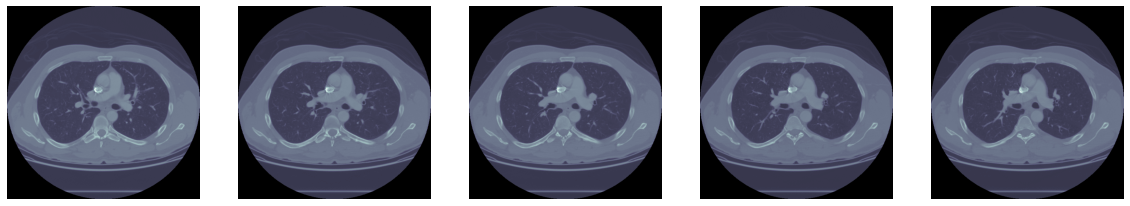

In [23]:
# A file of any CT scan can be taken, and then loaded for visual
example_file = "D:/School Work/University/Modules/Year 3/Machine Learning/Project/Dataset/Raw Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd"
img, origin, spacing = load_itk(example_file)

# To increase the number of visible slices, change the "1" (for rows) and "5" (for columns) in plt.subplots
fig, axes = plt.subplots(1,5, figsize=(20,20))
axes = axes.flatten()

# If increasing the number, change the range of "img[62:67]" to include the same number (or less) as previously established
for img, ax in zip(img[62:67], axes):
    ax.imshow(img, cmap = plt.cm.bone)
    ax.axis("off")

In [3]:
# The following code collects random slices from the CT scans, either visualising them with multiple or single examples
slice_count = []
all_scans = []

# Scan over every CT scan file, generate and append the image into the "all_scans" list
# and append the first value in shape (number of slices) to "slice_count" list
for file in os.scandir("D:\\School Work\\University\\Modules\\Year 3\\Machine Learning\\Project\\Dataset\\Raw Data"):
    if file.name[-4:] == ".mhd":
        itkimage = sitk.ReadImage(file.path)
        ct_scan = sitk.GetArrayFromImage(itkimage)

        all_scans.append(ct_scan)
        slice_count.append(ct_scan.shape[0])

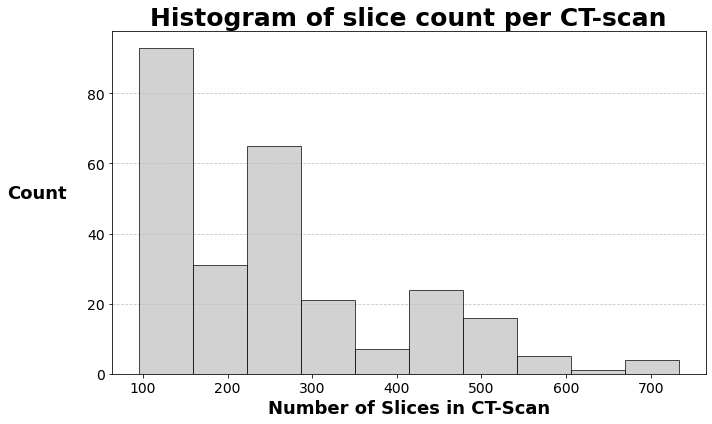

In [4]:
# Create a histogram plot for the slice count to examine the general size of the CT scans.
plt.figure(figsize=(10,6))
plt.hist(slice_count, zorder=2, color="silver", alpha=0.7, edgecolor = "black")
plt.title("Histogram of slice count per CT-scan", fontsize=25, fontweight="bold")

plt.xlabel("Number of Slices in CT-Scan", fontsize=18, fontweight="bold")
plt.ylabel("Count", rotation=0, labelpad=50, fontsize=18, fontweight="bold")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.grid(axis="y", zorder=0, alpha=0.7, linestyle='--')
plt.show()

In [5]:
# Get the mean, median, and the standard deviation
print(f"Mean: {stats.mean(slice_count)}\nMedian: {stats.median(slice_count)}\nStandard Deviation: {stats.stdev(slice_count)}")

Mean: 259.4719101123595
Median: 238
Standard Deviation: 139.784105006625


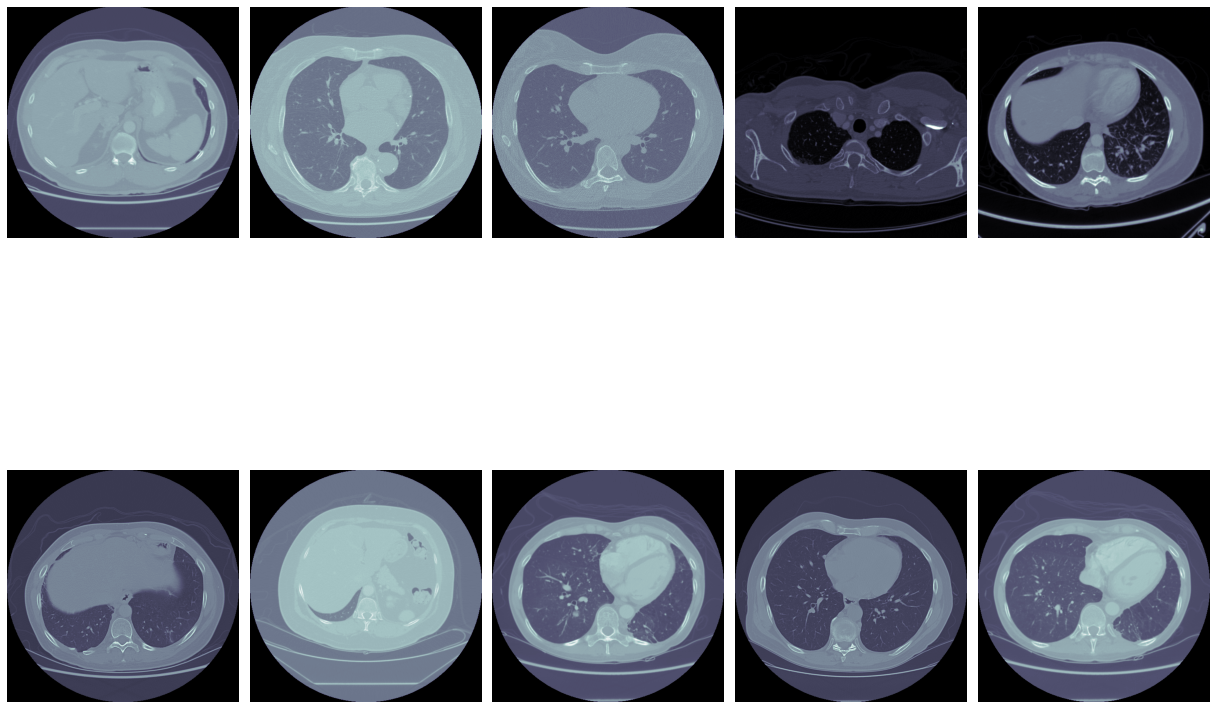

In [6]:
slices_random = []

# From the "all_scans" list, choose a random CT scan image and choose a random slice in that image
# To increase the number of examples, adjust the value inside the range
for i in range(10):
    scan = random.choice(all_scans) # Random Scan
    ct_slice = random.choice(scan) # Random Slice
    slices_random.append(ct_slice) 
    
# If the number of examples is changed, adjust accordingly in plt.subplots
fig, axes = plt.subplots(2,5, figsize=(17,17))
axes = axes.flatten()

for img, ax in zip(slices_random, axes):
    ax.axis("off")
    ax.imshow(img, cmap = plt.cm.bone)
    ax.set_aspect('equal')
    
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.tight_layout()

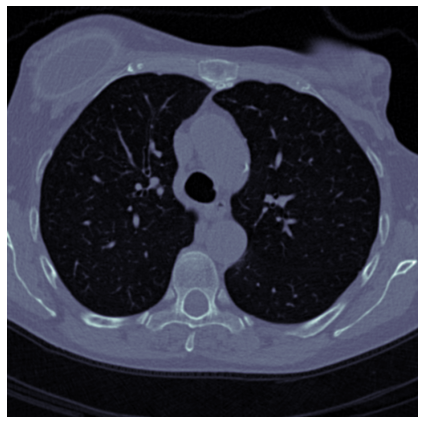

In [7]:
# For a single random image, the following code can be used
scan = random.choice(all_scans)
ct_slice = random.choice(scan)

fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.axis("off")
ax.imshow(ct_slice, cmap = plt.cm.bone)
ax.set_aspect('equal')
    
plt.subplots_adjust()
plt.tight_layout()

### Image Preprocessing

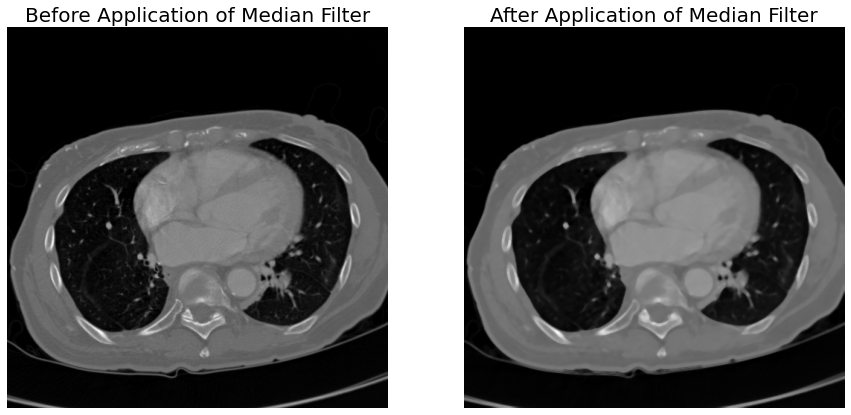

In [8]:
# This code takes a CT scan image slice and applies one of the preprocessing filters.
# This modified CT scan is then displayed.
img = sitk.GetArrayFromImage(sitk.ReadImage("D:/School Work/University/Modules/Year 3/Machine Learning/Project/Dataset/Raw Data/1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd"))

fig = plt.figure(figsize=(15,15))
plt.gray()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122) 
ascent = img[150]
# To change what kind of filter is used, change this line.
result = ndi.median_filter(ascent, (5,5))

# For example:
#1. Mean Filter
# result = blur(ascent, (5,5))

# 2. Gaussian Filter
# result = ndi.gaussian_filter(ascent, sigma=1.5)

ax1.set_title('Before Application of Median Filter', fontsize=20)
ax1.imshow(ascent, cmap="gray")
ax1.axis('off')

ax2.set_title('After Application of Median Filter', fontsize=20)
ax2.imshow(result, cmap="gray")
ax2.axis('off')

plt.show()

### Image Segmentation

In [9]:
# Modified get_segmented_lungs_plots() function that visualises each step of the image segmentation process.
def get_segmented_lungs_plots(im):
    
    f, plots = plt.subplots(8, 1, figsize=(5,40))
    
    # Plot step 1: Binary Conversion.
    binary = im < 604
    plots[0].axis("off")
    plots[0].imshow(binary, cmap=plt.cm.bone)
        
    # Plot step 2: Border Refinement.
    cleared = clear_border(binary)
    plots[1].axis("off")
    plots[1].imshow(cleared, cmap=plt.cm.bone)
        
    # Plot step 3: Region Labelling.
    label_image = label(cleared)
    plots[2].axis("off")
    plots[2].imshow(label_image, cmap=plt.cm.bone)
        
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:
                    label_image[coordinates[0], coordinates[1]] = 0
           
    # Plot step 4: Store Largest Areas.
    binary = label_image > 0
    plots[3].axis("off")
    plots[3].imshow(binary, cmap=plt.cm.bone)
        
    # Plot step 5: Binary Erosion.
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    plots[4].axis("off")
    plots[4].imshow(binary, cmap=plt.cm.bone)
        
    # Plot step 6: Binary Closing.
    selem = disk(10)
    binary = binary_closing(binary, selem)
    plots[5].axis('off')
    plots[5].imshow(binary, cmap=plt.cm.bone) 
        
    # Plot step 7: Fill Left Over Holes.
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    plots[6].axis('off')
    plots[6].imshow(binary, cmap=plt.cm.bone) 
        
    # Plot step 8: Superimpose Mask.
    get_high_values = binary == 0
    im[get_high_values] = 0
    plots[7].axis('off')
    plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

In [10]:
# Choose some ct image.
example_file = "D:\\School Work\\University\\Modules\\Year 3\\Machine Learning\\Project\\Dataset\\Raw Data\\1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd"

# Get the slices, origin and spacing.
img, origin, spacing = load_itk(example_file)

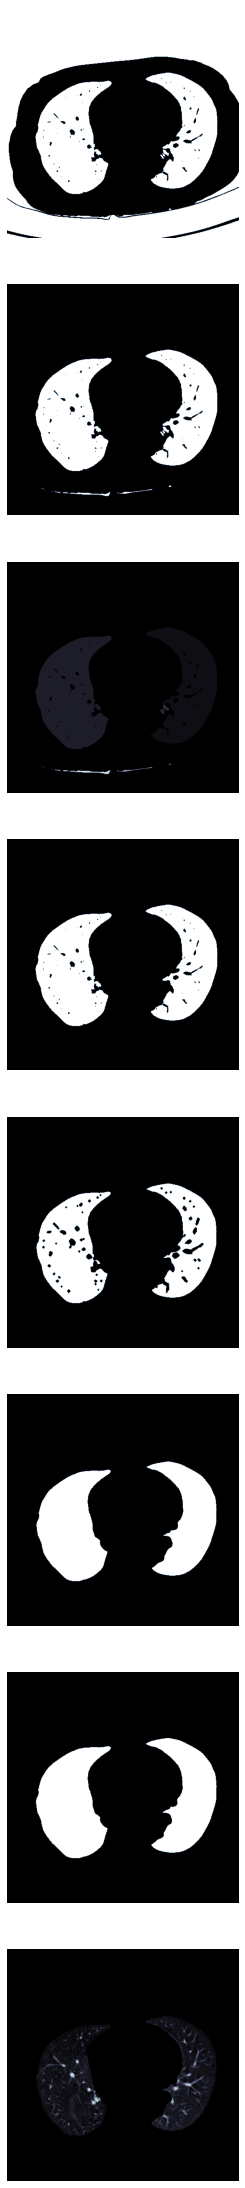

In [11]:
# Add 1024 to deal with intensity values.
new_img = img + 1024

# To change the slice selected in the image change the "160" index.
test1 = get_segmented_lungs_plots(new_img[160])

### Feature Extraction

In [12]:
# To visualise the generated X data, the following code can be used.
# Create a cartesian product from the arrays inside a single cubic voxel point.
def cartesian_product_broadcasted(*arrays):
    # Source: http://stackoverflow.com/a/11146645/190597
     
    # Using numpy's function "ix_", create an open mesh for easier access to sub-arrays.
    broadcastable = np.ix_(*arrays)
    # Broadcast arrays into a single array.
    broadcasted = np.broadcast_arrays(*broadcastable)
    # Retrieve the specific type of the data object.
    dtype = np.result_type(*arrays)
    # Get the rows and columns
    rows, cols = functools.reduce(np.multiply, broadcasted[0].shape), len(broadcasted)
    # Create new unitialized array
    out = np.empty(rows * cols, dtype=dtype)
    start, end = 0, rows
    # Fill the unitiliazed array by using previously broadcasted array
    for a in broadcasted:
        out[start:end] = a.reshape(-1)
        start, end = end, end + rows
    return out.reshape(cols, rows).T

def plot_voxel_coords(ct_slice):
    #Source: https://stackoverflow.com/questions/45969974/what-is-the-most-efficient-way-to-plot-3d-array-in-python
    
    # Set the size of the cube.
    size=36
    
    # Set volume depending on slice.
    volume = ct_slice
    
    # Retrieve the cartesian product.
    x, y, z = cartesian_product_broadcasted(*([np.arange(size, dtype='int16')]*3)).T

    # Create a mask for each coordinate and the volume.
    mask = ((x == 0) | (x == size-1) 
            | (y == 0) | (y == size-1) 
            | (z == 0) | (z == size-1))
    
    # Mask the coordinates and the volume.
    x = x[mask]
    y = y[mask]
    z = z[mask]
    volume = volume.ravel()[mask]
    
    return x, y, z, volume

In [13]:
# Load all the data from the directory containing the X data previously stored.
All_X_data = []

# Note: To change the voxels being viewed make sure to change the directory accordingly.
for file in os.scandir("D:/School Work/University/Modules/Year 3/Machine Learning/Project/Dataset/Pickled Mean Filter/"):
    with open(file.path, 'rb') as f:
        array = pickle.load(f)
        
        # Ensure to only retrieve the Xtrain files by checking the end of the string.
        if file.name[-8:-2] == "Xtrain":
            All_X_data.append(array)

In [19]:
random_voxels = []

# Select 5 random cubic voxels from the loaded data and store them in the "random voxels" list.
# To increase the number of cubic voxels, simply change the value in the range.
for i in range(5):
    X_voxels = random.choice(All_X_data)
    single_voxel = random.choice(X_voxels)
    
    random_voxels.append(single_voxel)

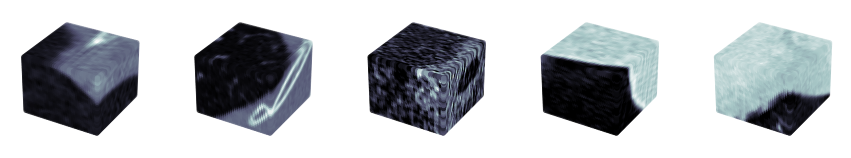

In [20]:
# This visual contains the voxel cubes cut out from the RAW data.

fig = plt.figure(figsize=(15,15))

# Create a subplot for each projection.
ax1 = fig.add_subplot(1, 5, 1, projection='3d')
ax2 = fig.add_subplot(1, 5, 2, projection='3d')
ax3 = fig.add_subplot(1, 5, 3, projection='3d')
ax4 = fig.add_subplot(1, 5, 4, projection='3d')
ax5 = fig.add_subplot(1, 5, 5, projection='3d')

# Store them in lists
axes = [ax1, ax2, ax3, ax4, ax5]

for index, ax in enumerate(axes):
    ax.axis("off")
    # Use previously defined "plot_voxel_coords" to get the required plotting information.
    x, y, z, volume = plot_voxel_coords(random_voxels[index])
    # Use the new x, y, z and volume to create a 3D visual of the voxels.
    ax.scatter(x, y, z, c=volume, cmap=plt.get_cmap('bone'))

plt.show()

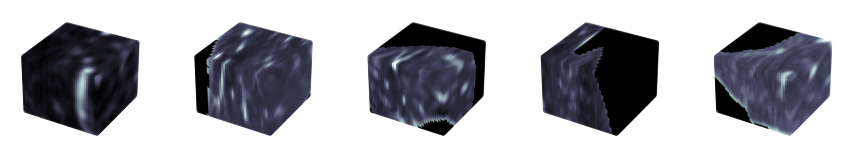

In [80]:
# This visual contains the voxel cubes cut out from the MODIFIED data.

fig = plt.figure(figsize=(15,15))

# Create a subplot for each projection.
ax1 = fig.add_subplot(1, 5, 1, projection='3d')
ax2 = fig.add_subplot(1, 5, 2, projection='3d')
ax3 = fig.add_subplot(1, 5, 3, projection='3d')
ax4 = fig.add_subplot(1, 5, 4, projection='3d')
ax5 = fig.add_subplot(1, 5, 5, projection='3d')

# Store them in lists
axes = [ax1, ax2, ax3, ax4, ax5]

for index, ax in enumerate(axes):
    ax.axis("off")
    # Use previously defined "plot_voxel_coords" to get the required plotting information.
    x, y, z, volume = plot_voxel_coords(random_voxels[index])
    # Use the new x, y, z and volume to create a 3D visual of the voxels.
    ax.scatter(x, y, z, c=volume, cmap=plt.get_cmap('bone'))

plt.show()

### Results and Discussion

In [19]:
# The values for the results that were previously noted down are put into lists
Raw = [81, 81, 80, 81, 81]
Filter = [84, 85.4, 85.2, 83, 84]
Segmentation = [87, 84.6, 92, 81.8, 87.4]
DCA = [88.8, 89.4, 88.4, 89.4, 88.6]

All = [Raw, Filter, Segmentation, DCA]

In [20]:
# To get the error 5 individual experiments are taken with their values

# First the standard deviation of the raw data is found
raw_acc = np.std([81,82,81,80,80])
raw_pre = np.std([77,83,79,81,83])
raw_sen = np.std([74,84,78,82,84])
raw_spe = np.std([88,70,85,77,76])
raw_f1s = np.std([82,81,82,79,79])

# Then the standard deviation of the raw data is found
dca_acc = np.std([87, 90, 88, 89, 90])
dca_pre = np.std([92, 88, 90, 86, 91])
dca_sen = np.std([81, 93, 86, 93, 89])
dca_spe = np.std([93, 88, 90, 85, 91])
dca_f1s = np.std([86, 90, 88, 89, 90])

raw_yerr = [raw_acc, raw_pre, raw_sen, raw_spe, raw_f1s] 
dca_yerr = [dca_acc, dca_pre, dca_sen, dca_spe, dca_f1s]

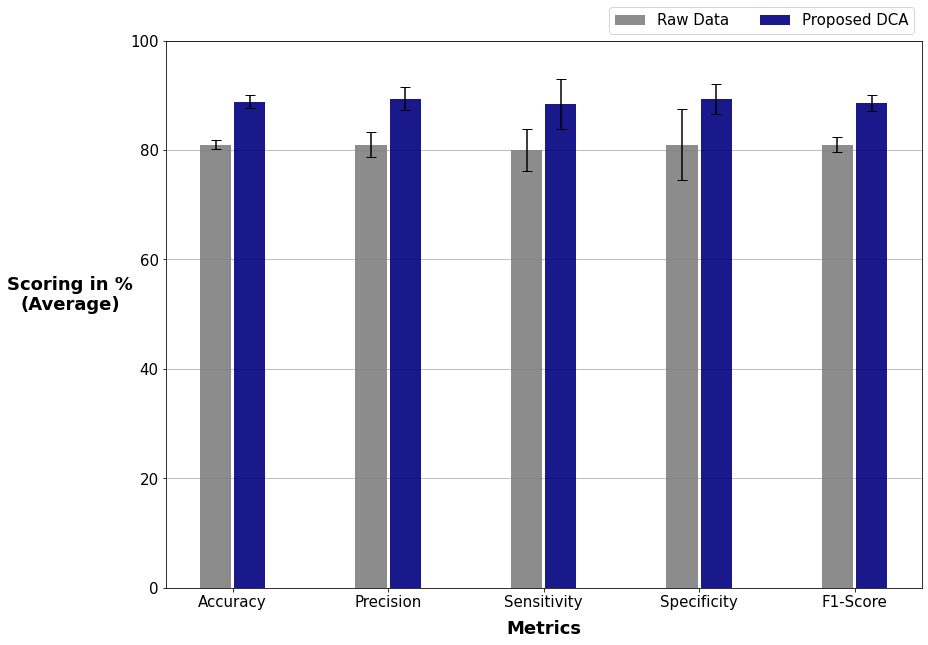

In [33]:
# Create a bar chart using the results to model the performance and compare the base vs the data-centric approach.
x = np.arange(5)
width = 0.2

plt.figure(figsize=(13,9))
plt.bar(x-0.11, Raw, width, color='gray', zorder=2, yerr=raw_yerr, capsize=5, alpha=0.9)
plt.bar(x+0.11, DCA, width, color='navy', zorder=2, yerr=dca_yerr, capsize=5, alpha=0.9)

plt.xticks(x, ["Accuracy", "Precision", "Sensitivity", "Specificity", "F1-Score"])
plt.xlabel("Metrics", fontsize=18, labelpad=10, fontweight="bold")
plt.xticks(fontsize=15)
plt.ylabel("Scoring in %\n(Average)", rotation=0, labelpad=60, fontsize=18, fontweight="bold")
plt.yticks(fontsize=15)
plt.ylim(ymax=100)

plt.legend(['Raw Data', 'Proposed DCA'], prop={'size': 15}, ncol=3, bbox_to_anchor=[1, 1.075])
plt.tight_layout()
plt.grid(axis='y', zorder=0)
plt.show()